# Equation of state (EOS) benchmarks on Fe-Ni-Cr alloy systems

This notebook provides an example workflow pipline from generating initial structures, executing high-throughput equation of state (EOS) workflow using multiples MLIPs, and analyzing the results from database.

The underlying structure generation code has been kindly shared by [Jan Jassen](https://github.com/jan-janssen) to call [structuretoolkit]() and [sqsgenerator](). If you found this example useful, please cite the following:

- Alvi, S. M. A. A., Janssen, J., Khatamsaz, D., Perez, D., Allaire, D., & Arroyave, R. (2024).
  Hierarchical Gaussian Process-Based Bayesian Optimization for Materials Discovery in High
  Entropy Alloy Spaces. *arXiv preprint arXiv:2410.04314*.
- Gehringer, D., Friák, M., & Holec, D. (2023). Models of configurationally-complex alloys made
  simple. *Computer Physics Communications, 286*, 108664.

## 1. Generate input structures

In [ ]:
from ase.build import bulk
from mlip_arena.tasks.eos_alloy.input import generate_alloy_db

In [ ]:
structure_template = bulk("Al", a=3.6, cubic=True).repeat([2, 2, 2])
elements = ["Fe", "Ni", "Cr"]
generate_alloy_db(structure_template, elements, upload=True)

## 2. Run benchmark at scale in parallel

In [1]:
from pathlib import Path

import pandas as pd
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from prefect_dask import DaskTaskRunner

from mlip_arena.models import REGISTRY
from mlip_arena.tasks.eos_alloy.flow import run_from_db

No module named 'deepmd'


In [ ]:
# Orchestrate workflow runner
# To deploy other types of cluster (e.g. PBS), refer to https://docs.dask.org/en/stable/deploying-hpc.html for details

nodes_per_alloc = 1
gpus_per_alloc = 4
ntasks = 1

cluster_kwargs = dict(
    cores=1,
    memory="64 GB",
    shebang="#!/bin/bash",
    account="m3828",
    walltime="00:30:00",
    job_mem="0",
    job_script_prologue=[
        "source ~/.bashrc",
        "module load python",
        "source activate /pscratch/sd/c/cyrusyc/.conda/mlip-arena",
    ],
    job_directives_skip=["-n", "--cpus-per-task", "-J"],
    job_extra_directives=[
        "-J eos",
        "-q regular",
        f"-N {nodes_per_alloc}",
        "-C gpu",
        f"-G {gpus_per_alloc}",
    ],
)

cluster = SLURMCluster(**cluster_kwargs)
print(cluster.job_script())
cluster.adapt(minimum_jobs=50, maximum_jobs=50)
client = Client(cluster)

run_from_db_ = run_from_db.with_options(
    task_runner=DaskTaskRunner(address=client.scheduler.address),
    # log_prints=True,
)

# Run the workflow

results = run_from_db_(
    db_path="sqs_Fe-Ni-Cr.db", out_path="eos.h5", table_name="Fe-Ni-Cr"
)

/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40791 instead
  warnings.warn(


#!/bin/bash

#SBATCH -A m3828
#SBATCH --mem=0
#SBATCH -t 00:30:00
#SBATCH -J eos
#SBATCH -q regular
#SBATCH -N 1
#SBATCH -C gpu
#SBATCH -G 4
source ~/.bashrc
module load python
source activate /pscratch/sd/c/cyrusyc/.conda/mlip-arena
/pscratch/sd/c/cyrusyc/.conda/mlip-arena/bin/python -m distributed.cli.dask_worker tcp://128.55.64.21:32827 --name dummy-name --nthreads 1 --memory-limit 59.60GiB --nanny --death-timeout 60



19:45:15.706 | INFO    | prefect.engine - Created flow run 'small-orca' for flow 'run-from-db'

19:45:15.711 | INFO    | prefect.engine - View at https://app.prefect.cloud/account/f7d40474-9362-4bfa-8950-ee6a43ec00f3/workspace/d4bb0913-5f5e-49f7-bfc5-06509088baeb/runs/flow-run/405009c6-b3c3-49fd-8cbe-dd7771281f0c

19:45:16.218 | INFO    | prefect.task_runner.dask - Connecting to existing Dask cluster SLURMCluster(293f6d25, 'tcp://128.55.64.21:32827', workers=0, threads=0, memory=0 B)

19:45:57.865 | INFO    | Task run 'get_atoms_from_db-936' - Created task run 'get_atoms_from_db-936' for task 'get_atoms_from_db'

19:46:27.860 | INFO    | Task run 'get_atoms_from_db-936' - Finished in state Completed()

## 3. Analyze results

In [2]:
import pandas as pd 
import numpy as np
from matplotlib import colors, ticker, colormaps
from matplotlib import pyplot as plt
from ase.formula import Formula
%matplotlib inline

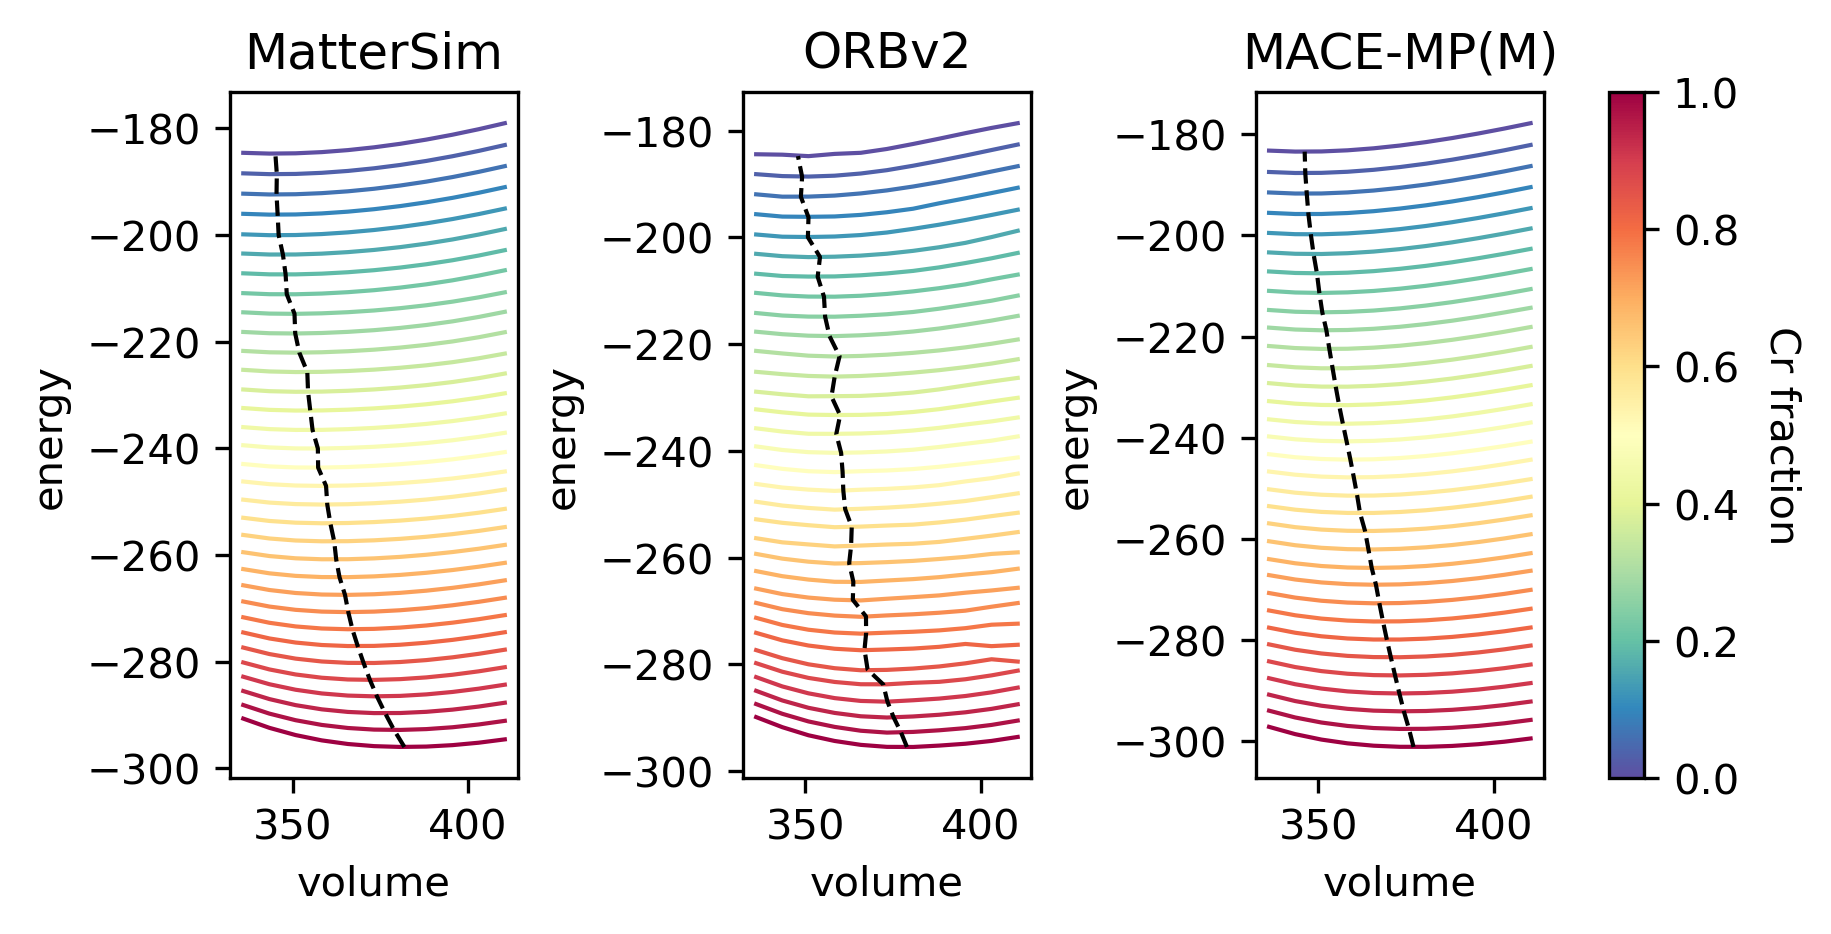

In [10]:
df = pd.read_hdf("eos.h5")

cmap = colormaps.get_cmap('Spectral').reversed()
norm = colors.Normalize(vmin=0, vmax=1)

formulae = [f for f in set(df['formula']) if 'Fe' not in f]
methods = set(df['method'])

with plt.style.context('default'):

    fig, axes = plt.subplots(
        ncols=len(methods),
        figsize=(6,3),
        layout='constrained',
        dpi=300
    )
    
    for i, method in enumerate(methods):
        ev0s = []
        for fi, formula in enumerate(formulae):
            filtered_data = df[(df['formula'] == formula) & (df['method'] == method)]
            filtered_data = filtered_data.drop_duplicates(subset=['method', 'formula', 'volume'], keep='last')
            
            ev0s.append((filtered_data['v0'].drop_duplicates()[0], filtered_data['e0'].drop_duplicates()[0]))
            c = Formula(formula) // Formula('Cr') / len(Formula(formula))
            # Plot EOS curves at different compositions
            axes[i].plot(
                filtered_data['volume'], filtered_data['energy'],
                c=cmap(norm(c)),
                lw=1
            )
            axes[i].set(
                title=method
            )

        # Plot equilibrium volume and energy line
        ev0s = np.array(sorted(ev0s, key=lambda x: x[1]))
        axes[i].plot(ev0s[:, 0], ev0s[:, 1], "--", color="black", lw=1)
        axes[i].set(
            xlabel='volume', ylabel='energy'
        )
    
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, orientation='vertical', aspect=20)
    cbar.set_label("Cr fraction", rotation=270, labelpad=15)
    plt.show()

In [7]:
# Calculate compositions
elements = set().union(*[set(Formula(f)) for f in df['formula']])

data = df.assign(**{
    k: df['formula'].map(
        lambda f: Formula(f).count()[k] / sum(Formula(f).count().values()) 
        if k in Formula(f).count() else 0
    )
    for k in elements
})

data

,method,formula,total_run_time,v0,e0,b0,b1,volume,energy,Cr,Ni,Fe
0,MatterSim,Cr11Ni21,0 days 00:00:28.339838,354.196669,-225.676697,0.785822,-1.069017,335.92320,-225.279831,0.34375,0.65625,0.000
1,MatterSim,Cr11Ni21,0 days 00:00:28.339838,354.196669,-225.676697,0.785822,-1.069017,343.38816,-225.582840,0.34375,0.65625,0.000
2,MatterSim,Cr11Ni21,0 days 00:00:28.339838,354.196669,-225.676697,0.785822,-1.069017,350.85312,-225.693726,0.34375,0.65625,0.000
3,MatterSim,Cr11Ni21,0 days 00:00:28.339838,354.196669,-225.676697,0.785822,-1.069017,358.31808,-225.655914,0.34375,0.65625,0.000
4,MatterSim,Cr11Ni21,0 days 00:00:28.339838,354.196669,-225.676697,0.785822,-1.069017,365.78304,-225.500259,0.34375,0.65625,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
6,MACE-MP(M),Cr26Fe4Ni2,0 days 00:00:00.433071,369.308334,-290.555581,1.228756,5.063066,380.71296,-290.349854,0.81250,0.06250,0.125
7,MACE-MP(M),Cr26Fe4Ni2,0 days 00:00:00.433071,369.308334,-290.555581,1.228756,5.063066,388.17792,-290.022858,0.81250,0.06250,0.125
8,MACE-MP(M),Cr26Fe4Ni2,0 days 00:00:00.433071,369.308334,-290.555581,1.228756,5.063066,395.64288,-289.561920,0.81250,0.06250,0.125
9,MACE-MP(M),Cr26Fe4Ni2,0 days 00:00:00.433071,369.308334,-290.555581,1.228756,5.063066,403.10784,-288.969910,0.81250,0.06250,0.125


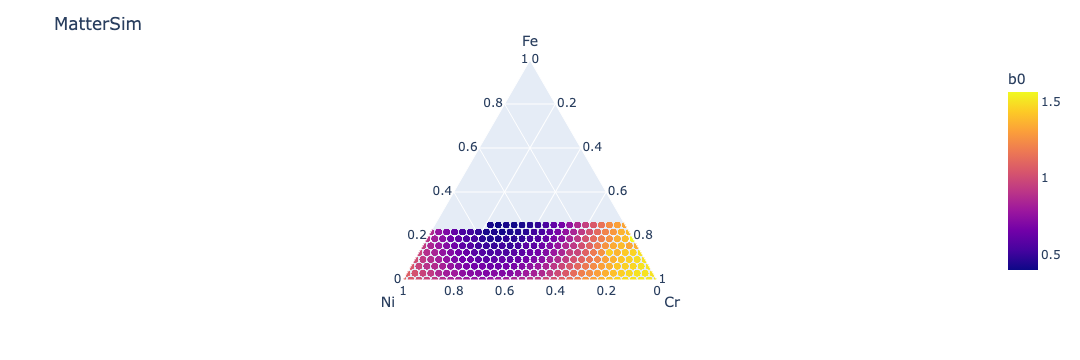

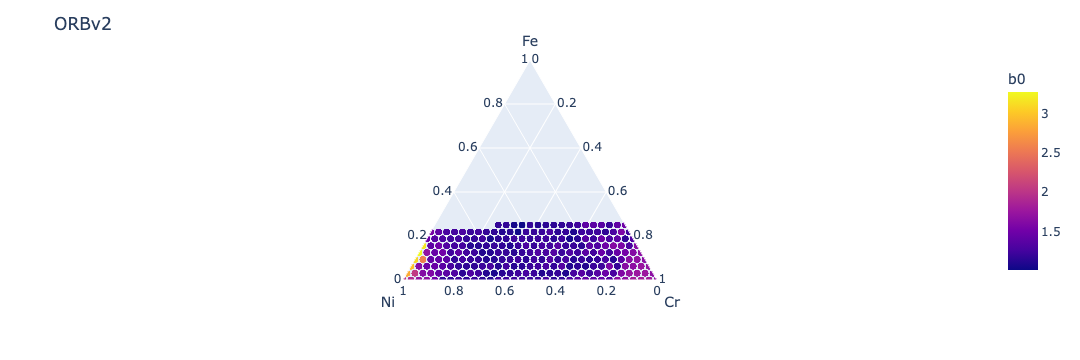

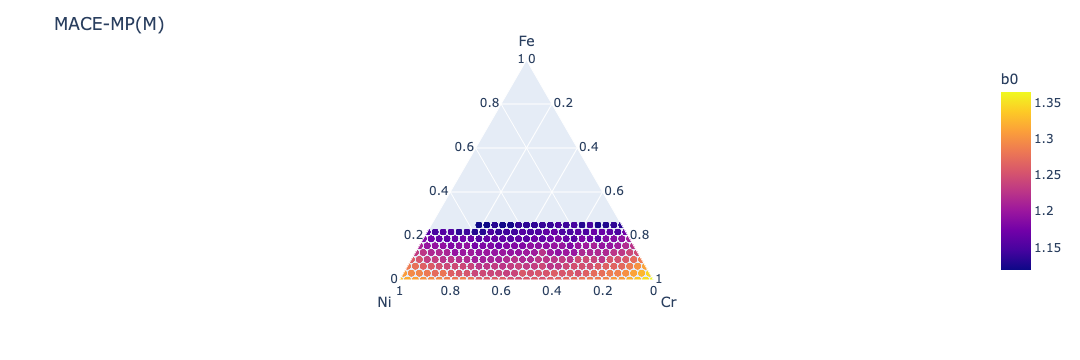

In [12]:
import plotly.express as px

for i, method in enumerate(methods):
    filtered_data = data[data['method'] == method]
    filtered_data = filtered_data.drop_duplicates(subset=['method', 'formula', 'volume'], keep='last')
    
    fig = px.scatter_ternary(
        filtered_data, a="Fe", b="Ni", c="Cr", color="b0", 
    )
    
    fig.update_layout(title=method)
    fig.show()